En esta sección, trabajaremos con el dataset SVHN (Street View House Numbers), correspondiente a imágenes naturales de dígitos de direcciones obtenidos desde Google Street View, sobre el cual se analizarán los beneficios de diferentes métodos convolucionales y de pooling.

### a)

Inicialmente se cargan los datos y se determina el tamaño de las imágenes, el número de clases diferentes y de ejemplos en cada categoría. A grandes rasgos se tiene un dataset con imagenes RGB de tamaño 32 x 32, dividido en un conjunto de entrenamiento (73257 ejemplos) y otro de prueba (26032 ejemplos), y etiquetado dentro de diez clases (una por cada dígito).

In [1]:
import scipy.io as sio
import numpy as np
import random
import matplotlib.pyplot as plt
#import cython
import h5py
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.models import load_model
import keras

Using TensorFlow backend.


In [2]:
train_data = sio.loadmat('../train_32x32.mat')
test_data = sio.loadmat('../test_32x32.mat')

# Cargar set de entrenamiento
X_train = train_data['X'].T
y_train = train_data['y'] - 1

# Cargar set de test
X_test = test_data['X'].T
y_test = test_data['y'] - 1

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Número de clases
n_classes = len(np.unique(y_train))

# Número de ejemplos
n_train = len(X_train)
n_test = len(X_test)

print ("Tamaño imágenes: " , np.shape(X_train[0])[1], "x", np.shape(X_train[0])[2])
print ("Número de clases:" , n_classes)

print ("\nNumero de ejemplos de entrenamiento por categoria:")
for i in np.unique(y_train):
    print ("Categoría",str(i), ":", str(np.where(y_train==i)[0].shape[0]), "ejemplos")
print ("Total ejemplos de entrenamiento:" , n_train)

print ("\nNumero de ejemplos de prueba por categoria:")
for i in np.unique(y_test):
    print ("Categoría",str(i), ":", str(np.where(y_test==i)[0].shape[0]), "ejemplos")
print ("Total ejemplos de test:" , n_test)

Tamaño imágenes:  32 x 32
Número de clases: 10

Numero de ejemplos de entrenamiento por categoria:
Categoría 0 : 13861 ejemplos
Categoría 1 : 10585 ejemplos
Categoría 2 : 8497 ejemplos
Categoría 3 : 7458 ejemplos
Categoría 4 : 6882 ejemplos
Categoría 5 : 5727 ejemplos
Categoría 6 : 5595 ejemplos
Categoría 7 : 5045 ejemplos
Categoría 8 : 4659 ejemplos
Categoría 9 : 4948 ejemplos
Total ejemplos de entrenamiento: 73257

Numero de ejemplos de prueba por categoria:
Categoría 0 : 5099 ejemplos
Categoría 1 : 4149 ejemplos
Categoría 2 : 2882 ejemplos
Categoría 3 : 2523 ejemplos
Categoría 4 : 2384 ejemplos
Categoría 5 : 1977 ejemplos
Categoría 6 : 2019 ejemplos
Categoría 7 : 1660 ejemplos
Categoría 8 : 1595 ejemplos
Categoría 9 : 1744 ejemplos
Total ejemplos de test: 26032


Luego, se visualizan 5 imágenes de entrenamiento y 5 de prueba elegidas aleatoriamente:

Set de Entrenamiento:


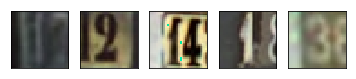

Set de Test:


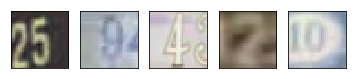

In [2]:
# Número de imágenes a mostrar
n_im = 5

print ("Set de Entrenamiento:")

# Se eligen n elementos al azar
index = random.sample(list(X_train), n_im)

for i in range(0,len(index)):      
    ax = plt.subplot(2, n_im, 1+i)
    im = index[i].reshape(3,32,32).transpose(2,1,0)
    plt.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
        
plt.show()

print ("Set de Test:")

# Se eligen n elementos al azar
index = random.sample(list(X_test), 5)

for i in range(0,len(index)):      
    ax = plt.subplot(1, n_im, 1+i)
    im = index[i].reshape(3,32,32).transpose(2,1,0)
    plt.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
    
plt.show()

Se presentan diez muestras aleatorias de la tarea de clasificación del dataset SVHN, cada una de las cuales es asignada a una etiqueta de un único dígito, correspondiente al dígito central de la imagen. Así, el hecho de que cada input pueda presentar dígitos secundarios dificulta la tarea, motivando aún más los potenciales buenos resultados que una red convolucional podría lograr. Esto último, sumado a las dificultades intrínsecas de cualquier tarea de reconocimiento de carácteres en contextos naturales (todas ellas presentes en el dataset) como fondos no contrastantes, baja resolución, desenfoque y/o considerables diferencias de iluminación, entregan resultados donde el mejor método computacional actual de clasificación sobre SVHN no logra superar el desempeño del humano (98.0%).

### b)

A continuación, se normalizan las imágenes dividiendo las intensidades originales de pixel por 255, mapeándolas al intervalo [0,1]. Además se modifica la representación de la salida a un vector binario con representación 'one hot encoding'.

In [61]:
X_train /= 255.0
X_test /= 255.0

Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

### c)

Se define una CNN con arquitectura _C x P x C x P x F x F_. Para la primera capa convolucional se utilizan 16 filtros de 5 x 5 y para la segunda 512 filtros de 7 x 7. Para la capa MLP escondida se usan 20 neuronas. Cabe destacar que esta arquitectura, con algunas diferencias, fue una de las primera CNNs entrenadas sobre SVHN consiguiendo una accuracy de 94.28%.

In [4]:
(n_channels, n_rows, n_cols) = np.shape(X_train[0])

model = Sequential()
model.add(Convolution2D(16, (5, 5), padding='same', activation='relu', input_shape=(n_channels, n_rows, n_cols)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(512, (7, 7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 32, 32)        1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 16, 16)       401920    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 512, 8, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                655380    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total para

A partir de este esquema es posible visualizar los cambios de dimensiones que experimenta un patrón de entrada a medida que se ejecuta un forward-pass. En términos generales, se observa que las capas convolucionales únicamente varian la cantidad de filtros con que el input es procesado. En cambio son las capas de pooling (método 'MaxPooling') quienes efectivamente reducen la dimensión del patrón de entrada, en particular cada imagen de entrada de tamaño 32 x 32 se reduce a 16 x 16 y a 8 x 8 luego de pasar por la primera y la segunda capa de pooling respectivamente (ambas de filtros tamaño 2 x 2). A continuación, se prepara la representación para entregársela a la capa MLP de 20 neuronas, por medio de una operación flatten que arroja un arreglo unidimensional de largo 512 x 8 x 8 = 32768. Finalmente, la capa de salida es representada por 10 neuronas (una por cada clase) encargadas de arrojar la clasificación resultante de la red.

In [5]:
model.compile(loss='binary_crossentropy', optimizer="adagrad", metrics=['accuracy'])
hist = model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, Y_test))

Train on 73257 samples, validate on 26032 samples
Epoch 1/10
73257/73257 [==============================] - 517s - loss: 0.2681 - acc: 0.9126 - val_loss: 0.2033 - val_acc: 0.9332
Epoch 2/10
73257/73257 [==============================] - 416s - loss: 0.1745 - acc: 0.9405 - val_loss: 0.1568 - val_acc: 0.9466
Epoch 3/10
73257/73257 [==============================] - 416s - loss: 0.1338 - acc: 0.9528 - val_loss: 0.1391 - val_acc: 0.9512
Epoch 4/10
73257/73257 [==============================] - 417s - loss: 0.1112 - acc: 0.9625 - val_loss: 0.1251 - val_acc: 0.9584
Epoch 5/10
73257/73257 [==============================] - 416s - loss: 0.0997 - acc: 0.9669 - val_loss: 0.1127 - val_acc: 0.9629
Epoch 6/10
73257/73257 [==============================] - 416s - loss: 0.0921 - acc: 0.9696 - val_loss: 0.1078 - val_acc: 0.9646
Epoch 7/10
73257/73257 [==============================] - 416s - loss: 0.0865 - acc: 0.9714 - val_loss: 0.1053 - val_acc: 0.9659
Epoch 8/10
73257/73257 [=======================

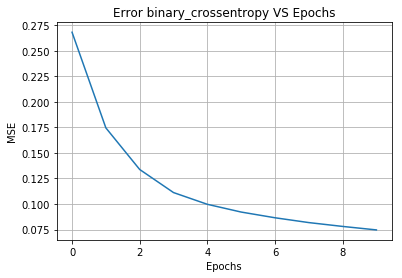

In [6]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error binary_crossentropy VS Epochs")
plt.plot(hist.epoch, hist.history['loss'])
plt.grid(True)

plt.show()

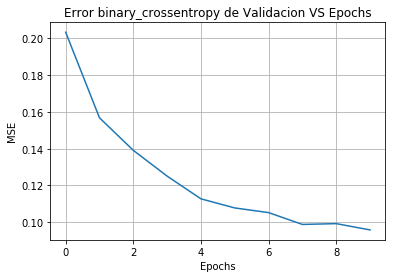

In [7]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error binary_crossentropy de Validacion VS Epochs")
plt.plot(hist.epoch, hist.history['val_loss'])
plt.grid(True)

plt.show()

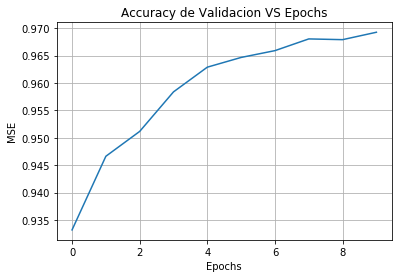

In [8]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Accuracy de Validacion VS Epochs")
plt.plot(hist.epoch, hist.history['val_acc'])
plt.grid(True)

plt.show()

***d)***

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D

(n_channels, n_rows, n_cols) = np.shape(X_train[0])

def generate_model(cf_size, cp_size):
    model = Sequential()
    model.add(Convolution2D(16,(cf_size,cf_size), padding='same',activation='relu',input_shape=(n_channels, n_rows, n_cols)))
    model.add(MaxPooling2D(pool_size=(cp_size,cp_size)))
    model.add(Convolution2D(512,(cf_size,cf_size), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(cp_size,cp_size)))
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    return model

# Tamaño capas convolucionales
cf_size = [3,5,7,9]
# Tamaño capas de pooling
cp_size = [2,4]

for i in cf_size:
    for j in cp_size:
        model = generate_model(i,j)
        #print "Modelo con tamaño capa convolucional: ", i, " y tamaño capa de pooling: ", j
        #model.summary()

In [4]:
# Tamaño capas convolucionales
cf_size = [3,5,7,9]
# Tamaño capas de pooling
cp_size = [2,4]

for i in cf_size:
    for j in cp_size:            
        print ("Modelo con tamaño capa convolucional: ", i, " y tamaño capa de pooling: ", j)
        model = generate_model(i,j)
        model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
        model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, Y_test))
        model.save('entrenamientos/3d-'+str(i)+'-'+str(j)+'-neuronas.h5')

Modelo con tamaño capa convolucional:  3  y tamaño capa de pooling:  4
Train on 73257 samples, validate on 26032 samples
Epoch 1/10
73257/73257 [==============================] - 136s - loss: 0.2891 - acc: 0.9055 - val_loss: 0.2483 - val_acc: 0.9123
Epoch 2/10
73257/73257 [==============================] - 90s - loss: 0.2232 - acc: 0.9205 - val_loss: 0.1948 - val_acc: 0.9279
Epoch 3/10
73257/73257 [==============================] - 89s - loss: 0.1818 - acc: 0.9322 - val_loss: 0.1700 - val_acc: 0.9369
Epoch 4/10
73257/73257 [==============================] - 91s - loss: 0.1610 - acc: 0.9400 - val_loss: 0.1637 - val_acc: 0.9388
Epoch 5/10
73257/73257 [==============================] - 95s - loss: 0.1489 - acc: 0.9448 - val_loss: 0.1489 - val_acc: 0.9451
Epoch 6/10
73257/73257 [==============================] - 91s - loss: 0.1410 - acc: 0.9481 - val_loss: 0.1430 - val_acc: 0.9472
Epoch 7/10
73257/73257 [==============================] - 93s - loss: 0.1350 - acc: 0.9503 - val_loss: 0.1367 

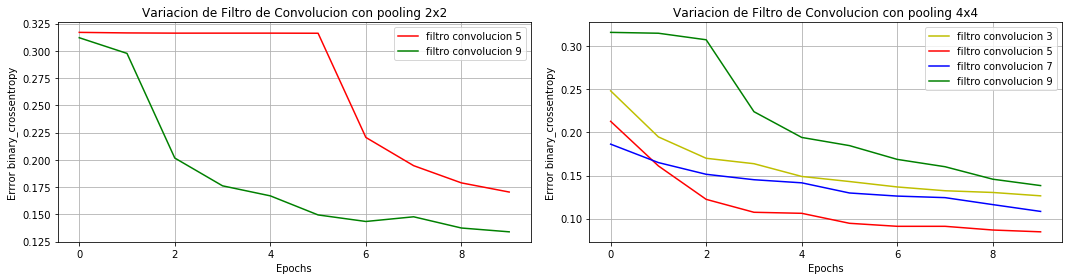

In [53]:
error3x4=[0.2483,0.1948,0.1700,0.1637,0.1489,0.1430,0.1367,0.1323,0.1303,0.1264]
error5x2=[0.3170,0.3165,0.3163, 0.3163, 0.3163 ,0.3162 , 0.2206 , 0.1947 , 0.1789,0.1705 ]
error5x4=[ 0.2129 , 0.1611 , 0.1223 , 0.1073 , 0.1061 , 0.0945 , 0.0910 , 0.0910 , 0.0867 , 0.0846]
error7x2=[ 2.5781 , 2.5781, 2.5781,2.5781 , 2.5781 , 2.5781 , 2.5781 , 2.5781, 2.5781 , 2.5781 ]
error7x4=[ 0.1864, 0.1650 , 0.1514 , 0.1451 , 0.1415 ,0.1297 , 0.1261 , 0.1243 , 0.1162 , 0.1083 ]
error9x2=[0.3121 , 0.2977 , 0.2017 , 0.1762 , 0.1670 , 0.1495 , 0.1435 , 0.1478 , 0.1375 , 0.1340 ]
error9x4=[0.3162 , 0.3152, 0.3076 , 0.2241, 0.1942 , 0.1847, 0.1687 , 0.1602 ,0.1457 , 0.1383 ]

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.xlabel("Epochs")
plt.ylabel("Errror binary_crossentropy")
plt.title("Variacion de Filtro de Convolucion con pooling 2x2")
plt.plot(error5x2, label='filtro convolucion 5' , color='r')
#plt.plot(error7x2, label='filtro convolucion 7', color='b')
plt.plot(error9x2, label='filtro convolucion 9', color='g')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlabel("Epochs")
plt.ylabel("Errror binary_crossentropy")
plt.title("Variacion de Filtro de Convolucion con pooling 4x4")
plt.plot(error3x4, label='filtro convolucion 3', color='y')
plt.plot(error5x4, label='filtro convolucion 5', color='r')
plt.plot(error7x4, label='filtro convolucion 7', color='b')
plt.plot(error9x4, label='filtro convolucion 9', color='g')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



### e)

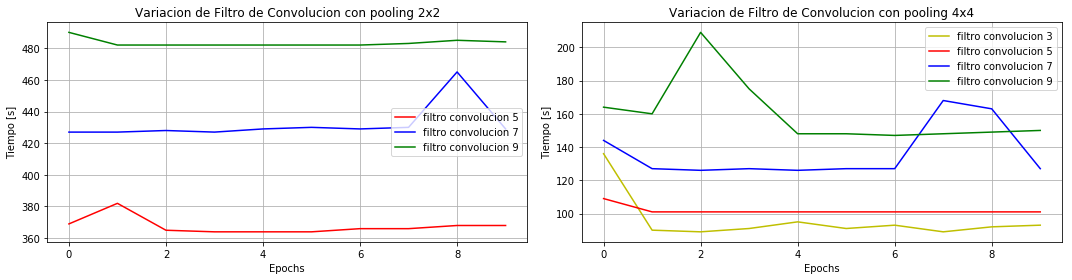

In [49]:
tiempo3x4=[136,90,89,91,95,91,93,89,92,93]
tiempo5x2=[369,382,365,364,364,364,366,366,368,368]
tiempo5x4=[109,101,101,101,101,101,101,101,101,101]
tiempo7x2=[427,427,428,427,429,430,429,430,465,429]
tiempo7x4=[144,127,126,127,126,127,127,168,163,127]
tiempo9x2=[490,482,482,482,482, 482,482,483,485,484]
tiempo9x4=[164,160,209,175,148,148,147,148,149,150]

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.xlabel("Epochs")
plt.ylabel("Tiempo [s]")
plt.title("Variacion de Filtro de Convolucion con pooling 2x2")
plt.plot(tiempo5x2, label='filtro convolucion 5' , color='r')
plt.plot(tiempo7x2, label='filtro convolucion 7', color='b')
plt.plot(tiempo9x2, label='filtro convolucion 9', color='g')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.xlabel("Epochs")
plt.ylabel("Tiempo [s]")
plt.title("Variacion de Filtro de Convolucion con pooling 4x4")
plt.plot(tiempo3x4, label='filtro convolucion 3', color='y')
plt.plot(tiempo5x4, label='filtro convolucion 5', color='r')
plt.plot(tiempo7x4, label='filtro convolucion 7', color='b')
plt.plot(tiempo9x4, label='filtro convolucion 9', color='g')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [64]:
# Tamaño capas convolucionales
cf_size = [3,5,7,9]
# Tamaño capas de pooling
cp_size = [2,4]

resultados= {}

for i in cf_size:
    for j in cp_size:
        model = load_model('entrenamientos/3d-'+str(i)+'-'+str(j)+'-neuronas.h5')
        resultados[str(i)+'x'+str(j)] = model.evaluate(X_test, Y_test)

26032/26032 [==============================] - 194s   


In [73]:
for j in cp_size:
    print ('Para capa de Pooling con tamano '+ str(j))
    print ('Accuracy en conjunto de test:\t' + '3x'+str(j)+
           '\t\t 5x'+str(j)+
           '\t\t 7x'+str(j)+
           '\t\t 9x'+str(j))
    print ("\t \t \t \t" + str(resultados['3x'+str(j)][1])+
           '\t'+ str(resultados['5x'+str(j)][1])+
           '\t'+ str(resultados['7x'+str(j)][1])+
           '\t'+ str(resultados['9x'+str(j)][1]))
        
    

Para capa de Pooling con tamano 2
Accuracy en conjunto de test:	3x2		 5x2		 7x2		 9x2
	 	 	 	0.962265690961	0.936904603305	0.839174912836	0.950076850265
Para capa de Pooling con tamano 4
Accuracy en conjunto de test:	3x4		 5x4		 7x4		 9x4
	 	 	 	0.954759548541	0.97218809226	0.961681796718	0.951148608014


### G

In [75]:
selectModel= load_model('entrenamientos/3d-5-4-neuronas.h5') #5x4
selectModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 16, 32, 32)        1216      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 8, 8)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 512, 8, 8)         205312    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 512, 2, 2)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 20)                40980     
_________________________________________________________________
dense_22 (Dense)             (None, 10)                210       
Total para

In [112]:
layers = selectModel.layers
capa1 = layers[0] #se define primera capa
pesos1= np.array(capa1.get_weights())

print ('Pesos Primera Capa Convolucional')
print (capa1.get_config())
print (pesos1[0].shape)
print (pesos1[0])

Pesos Primera Capa Convolucional
{'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': u'uniform', 'scale': 1.0, 'seed': None, 'mode': u'fan_avg'}}, 'name': u'conv2d_21', 'kernel_constraint': None, 'bias_regularizer': None, 'bias_constraint': None, 'dtype': u'float32', 'activation': 'relu', 'trainable': True, 'data_format': u'channels_first', 'padding': u'same', 'strides': (1, 1), 'dilation_rate': (1, 1), 'kernel_regularizer': None, 'kernel_size': (5, 5), 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'batch_input_shape': (None, 3, 32, 32), 'use_bias': True, 'activity_regularizer': None, 'filters': 16}
(5, 5, 3, 16)
[[[[ -9.75923464e-02   4.77411821e-02   1.01810828e-01 ...,
      7.51539366e-03  -7.26575404e-02  -1.20637946e-01]
   [ -3.41341011e-02  -1.08899370e-01  -4.10671905e-02 ...,
      6.22195601e-02  -1.17263809e-01  -1.09118097e-01]
   [ -1.01508096e-01   6.46763369e-02  -6.94949999e-02 ...,
      9.50330198e-02  -1.50042668e-01  -2.